<a href="https://colab.research.google.com/github/matteraggi/maritimeAIS/blob/main/TrainingAIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install + Import**

In [2]:
# === Installazioni necessarie su Colab ===
!pip install pandas numpy pyarrow torch matplotlib scikit-learn

import pandas as pd
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import random, os
from pyproj import Transformer
from google.colab import drive
import math
import json

# **Mount Drive**

In [3]:
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


# **Parametri**

In [4]:
# --- CONFIG ---
SEQUENCE_LEN = 30
DELTA_T = "1min"
FEATURES = [
    # posizione relativa (verrà centrata in create_sequences)
    "X", "Y",

    # dinamica
    "dX", "dY",               # movimenti locali (in metri)
    "speed_xy",               # velocità in m/s
    "accel_xy",               # accelerazione
    "turn_rate",              # rotazione nave
    "dir_xy",                 # direzione in radianti

    # stato AIS
    "SOG", "COG", "Heading",

    # derivate AIS
    "dSOG", "dCOG", "dHeading",

    # statistiche dinamiche (smooth)
    "speed_xy_mean10", "speed_xy_std10",
    "SOG_mean10", "SOG_std10",
    "COG_mean10", "COG_std10",
    "Heading_mean10", "Heading_std10",

    # classificazione nave
    "VesselType"
]

TARGET_IDX = [0, 1]   # prevedi solo X,Y (posizione futura)
TEST_RATIO = 0.15   #dataset per test
VAL_RATIO = 0.15    #dataset per validation
MMSI_SEED = 42
torch.manual_seed(MMSI_SEED)
np.random.seed(MMSI_SEED)
random.seed(MMSI_SEED)
FUTURE_LEN = 10

# MODEL HP
INPUT_SIZE = len(FEATURES)
HIDDEN_SIZE = 128            # Dimensione dello stato nascosto dell’RNN
NUM_LAYERS = 2               # Numero di strati di LSTM
LR = 1e-3                    # Learning rate dell’ottimizzatore (alto -> instabile, basso -> lento)
BATCH_SIZE = 128             # Quante sequenze passi al modello per step di aggiornamento
EPOCHS = 10
EARLY_STOPPING_PATIENCE = 5

# ATTACK / EVAL
STD_X_M = None   # se calcoli fuori, assegna qui
STD_Y_M = None

# ANOMALIES
ATTACK_ENABLE = True
ATTACK_PROB   = 0.3       # percentuale (0-1) di elementi attaccati
DRIFT_METERS  = 10000
DRIFT_SWEEP_METERS = [2000, 5000, 10000, 20000]

# **Load Dataset e JSON**

In [5]:
# === PATH ===
BASE_PATH = "/content/drive/MyDrive/preprocessed"
DATA_FILE = f"{BASE_PATH}/ais_final.parquet"
MEAN_FILE = f"{BASE_PATH}/feature_means.json"
STD_FILE  = f"{BASE_PATH}/feature_stds.json"

# === CARICAMENTO DATASET ===
df = pd.read_parquet(DATA_FILE)
print("Righe totali:", len(df))

# === CARICAMENTO STATISTICHE ===
with open(MEAN_FILE, "r") as f:
    feature_means = json.load(f)
with open(STD_FILE, "r") as f:
    feature_stds = json.load(f)

print("Feature means:", feature_means)
print("Feature stds:", feature_stds)

# === CALCOLO SCALE METRICHE (X,Y reali) ===
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32616", always_xy=True)
xs_m, ys_m = transformer.transform(df["LON"].values, df["LAT"].values)
STD_X_M = float(xs_m.std()) if STD_X_M is None else STD_X_M
STD_Y_M = float(ys_m.std()) if STD_Y_M is None else STD_Y_M
print(f"STD_X_M={STD_X_M:.2f} m  STD_Y_M={STD_Y_M:.2f} m")

# === SPLIT PER MMSI ===
mmsi_list = df["MMSI"].unique()
rng = np.random.RandomState(MMSI_SEED)
rng.shuffle(mmsi_list)

n = len(mmsi_list)
n_test = int(TEST_RATIO * n)
n_val  = int(VAL_RATIO * n)

test_mmsi = mmsi_list[:n_test]
val_mmsi  = mmsi_list[n_test:n_test+n_val]
train_mmsi = mmsi_list[n_test+n_val:]

df_train = df[df["MMSI"].isin(train_mmsi)]
df_val   = df[df["MMSI"].isin(val_mmsi)]
df_test  = df[df["MMSI"].isin(test_mmsi)]

print(f"Train navi: {len(train_mmsi)}, Val navi: {len(val_mmsi)}, Test navi: {len(test_mmsi)}")

available = [f for f in FEATURES if f in df.columns]
print(df[available].describe().T[["mean", "std", "min", "max"]])
print("Missing values:\n", df[available].isna().sum())

Righe totali: 185731
Feature means: {'X': 209699.3485615882, 'Y': 3296090.3875009352, 'SOG': 1.4261196561, 'COG': 209.004364761, 'Heading': 236.4842529435}
Feature stds: {'X': 33332.4555200091, 'Y': 33116.4317524409, 'SOG': 2.8284330102, 'COG': 107.2568647914, 'Heading': 121.3349535405}
STD_X_M=33329.30 m  STD_Y_M=33116.41 m
Train navi: 14, Val navi: 2, Test navi: 2
                         mean        std         min         max
X                4.124750e-05   0.999908   -5.343412    2.167709
Y               -5.142053e-06   1.000002   -2.824842    0.837053
dX               1.549511e-05   0.002132   -0.036173    0.018574
dY              -1.901964e-05   0.001865   -0.018828    0.015385
speed_xy         1.203287e-03   0.002564    0.000000    0.040780
accel_xy         1.969884e-07   0.000979   -0.034585    0.040780
turn_rate        7.765470e-06   0.315192   -3.749950    3.304901
dir_xy           1.462060e+01  95.661242 -179.986800  179.997082
SOG             -1.890219e-05   0.999979   -0.

# **Creazione finestre temporali per train, val e test**

In [6]:
def create_sequences(df, seq_len, future_len, features, std_xy=None):
    Xs, Ys, owners = [], [], []

    for mmsi, g in df.groupby("MMSI"):
        g = g.sort_values("BaseDateTime")

        A = g[features].copy()

        # denormalizza X,Y in metri reali
        A["X"] = A["X"] * feature_stds["X"] + feature_means["X"]
        A["Y"] = A["Y"] * feature_stds["Y"] + feature_means["Y"]

        data = A.to_numpy()
        XY = A[["X","Y"]].to_numpy()

        for s in range(len(data) - seq_len - future_len):

            hist      = data[s:s+seq_len].copy()
            last_xy   = XY[s + seq_len - 1]

            # history centrata
            hist[:,0] -= last_xy[0]
            hist[:,1] -= last_xy[1]

            # target relativo
            fut_abs = XY[s+seq_len:s+seq_len+future_len]
            fut_rel = fut_abs - last_xy

            # scaling differenziato
            if std_xy is not None:
                hist[:,0]     /= std_xy[0]
                hist[:,1]     /= std_xy[1]
                fut_rel[:,0]  /= std_xy[0]
                fut_rel[:,1]  /= std_xy[1]

            Xs.append(hist)
            Ys.append(fut_rel)
            owners.append((mmsi, s))

    return np.array(Xs), np.array(Ys), owners

In [7]:
X_tmp, y_tmp, _ = create_sequences(df_train, SEQUENCE_LEN, FUTURE_LEN, FEATURES, std_xy=None)

dx = y_tmp[...,0].ravel()
dy = y_tmp[...,1].ravel()

std_x = np.std(dx)
std_y = np.std(dy)

print("STD_X =", std_x)
print("STD_Y =", std_y)

std_xy = (std_x, std_y)


X_train, y_train, owners_train = create_sequences(df_train, SEQUENCE_LEN, FUTURE_LEN, FEATURES, std_xy)
X_val,   y_val,   owners_val   = create_sequences(df_val,   SEQUENCE_LEN, FUTURE_LEN, FEATURES, std_xy)
X_test,  y_test,  owners_test  = create_sequences(df_test,  SEQUENCE_LEN, FUTURE_LEN, FEATURES, std_xy)

print(f"Train: {len(X_train)}  Val: {len(X_val)}  Test: {len(X_test)}")

STD_X = 394.83595297139254
STD_Y = 351.91378726632234
Train: 150615  Val: 12878  Test: 21518


In [8]:
def sanity_check_scaled(name, y_scaled):
    print(f"\n=== SANITY CHECK (scaled) — {name} ===")
    print("min:", y_scaled.min(), "max:", y_scaled.max())
    print("mean:", y_scaled.mean(), "std:", y_scaled.std())
    print("percentiles:", np.percentile(y_scaled, [1,10,50,90,99]))


sanity_check_scaled("TRAIN", y_train)
sanity_check_scaled("VAL",   y_val)
sanity_check_scaled("TEST",  y_test)


=== SANITY CHECK (scaled) — TRAIN ===
min: -11.590883630006182 max: 10.357895495833361
mean: -0.0027797583856845006 std: 1.0000221405433998
percentiles: [-3.7559417  -0.2387077   0.          0.20174318  3.81335266]

=== SANITY CHECK (scaled) — VAL ===
min: -9.070747537664555 max: 7.772403683188602
mean: 0.009456083545230708 std: 0.7154017340650325
percentiles: [-2.69075593 -0.00967523  0.          0.00965784  3.00210945]

=== SANITY CHECK (scaled) — TEST ===
min: -8.0261599816903 max: 7.445946299078104
mean: 0.0010685242408791078 std: 1.1323935038865158
percentiles: [-3.72968671 -0.94550721  0.          0.93179554  3.85370479]


# **Check Dataset**

In [9]:
def check_dataset_sanity(X, y, name="train"):
    print(f"\n=== SANITY CHECK: {name.upper()} ===")

    # History absolute scale
    print("\n-- History (first 2 features = X_rel, Y_rel) --")
    print("  min:", X[...,0:2].min(), "max:", X[...,0:2].max())
    print("  mean:", X[...,0:2].mean())
    print("  std:", X[...,0:2].std())

    # Future relative target
    print("\n-- Future ΔX, ΔY (y) --")
    print("  min:", y.min(axis=(0,1)))
    print("  max:", y.max(axis=(0,1)))
    print("  mean:", y.mean(axis=(0,1)))
    print("  std:", y.std(axis=(0,1)))

    # Distribution summary
    print("\n-- Percentiles ΔX, ΔY --")
    print("  1%:",  np.percentile(y, 1))
    print("  10%:", np.percentile(y, 10))
    print("  50%:", np.percentile(y, 50))
    print("  90%:", np.percentile(y, 90))
    print("  99%:", np.percentile(y, 99))

# run checks
check_dataset_sanity(X_train, y_train, "train")
check_dataset_sanity(X_val, y_val, "val")
check_dataset_sanity(X_test, y_test, "test")


=== SANITY CHECK: TRAIN ===

-- History (first 2 features = X_rel, Y_rel) --
  min: -26.9410743831368 max: 29.6738514983417
  mean: 0.006359898817384713
  std: 2.374016223306229

-- Future ΔX, ΔY (y) --
  min: [ -9.20089173 -11.59088363]
  max: [10.3578955  10.27452363]
  mean: [ 0.00387468 -0.0094342 ]
  std: [1. 1.]

-- Percentiles ΔX, ΔY --
  1%: -3.755941696419741
  10%: -0.23870770042997988
  50%: 0.0
  90%: 0.2017431822310191
  99%: 3.8133526559585

=== SANITY CHECK: VAL ===

-- History (first 2 features = X_rel, Y_rel) --
  min: -19.52681325536553 max: 17.04944972430727
  mean: -0.024238648763912612
  std: 1.8206175940375862

-- Future ΔX, ΔY (y) --
  min: [-5.05127943 -9.07074754]
  max: [7.77240368 7.47146978]
  mean: [ 0.02925635 -0.01034418]
  std: [0.76177466 0.66521767]

-- Percentiles ΔX, ΔY --
  1%: -2.6907559289485303
  10%: -0.00967523124141395
  50%: 0.0
  90%: 0.009657835585066929
  99%: 3.002109446687181

=== SANITY CHECK: TEST ===

-- History (first 2 features = X

# **LSTM model (Long Short Term Memory)**

In [10]:
class TrajectoryLSTM(nn.Module):
    def __init__(self, input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, output_size=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=NUM_LAYERS, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # ultima uscita
        return out

#model_lstm = TrajectoryLSTM()
#criterion = nn.SmoothL1Loss()
#optimizer = torch.optim.Adam(model_lstm.parameters(), lr=LR)


class LSTMSeq2Seq(nn.Module):
    def __init__(self, input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, future_len=30):
        super().__init__()
        self.future_len = future_len

        self.encoder = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.decoder = nn.LSTM(2, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        # --- encoder ---
        _, (h, c) = self.encoder(x)

        # inizializza decoder con vettore nullo (partenza)
        y_prev = torch.zeros((x.size(0), 1, 2), device=x.device)

        outputs = []

        for _ in range(self.future_len):
            out, (h, c) = self.decoder(y_prev, (h, c))
            step = self.fc(out)          # (B, 1, 2)
            outputs.append(step)
            y_prev = step                # autoregressivo

        return torch.cat(outputs, dim=1)  # (B, future_len, 2)

Il modello ha Encoder seq2seq, Decoder seq2seq e Output finale.

L'Encoder prende la finestra di input (history), comprime l’informazione in uno stato nascosto e grazie al BiLSTM capisce anche la “geometria” della finestra,

Il Decider genera un punto futuro alla volta, ciascun punto dipende da quello prima MA durante training viene stabilizzato con teacher forcing.

L'Output finale è (future_len, 2) = la traiettoria futura.

Quindi segue esattamente la filosofia seq2seq, solo migliorata.

In [11]:
class BiLSTMSeq2Seq(nn.Module):
    def __init__(
        self,
        input_size,
        enc_hidden_size,
        dec_hidden_size,
        num_layers,
        future_len,
        dropout=0.2
    ):
        super().__init__()

        self.future_len = future_len
        self.enc_hidden_size = enc_hidden_size
        self.dec_hidden_size = dec_hidden_size
        self.num_layers = num_layers

        # --- Encoder: BiLSTM ---
        self.encoder = nn.LSTM(
            input_size=input_size,
            hidden_size=enc_hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )

        # Uscita encoder = 2 * enc_hidden_size (forward + backward)
        self.enc_out_size = enc_hidden_size * 2

        # Bottleneck: comprime il contesto BiLSTM nello spazio del decoder
        self.enc2dec_h = nn.Linear(self.enc_out_size, dec_hidden_size)
        self.enc2dec_c = nn.Linear(self.enc_out_size, dec_hidden_size)

        # --- Decoder LSTM (unidirezionale) ---
        self.decoder = nn.LSTM(
            input_size=2,               # input = (ΔX, ΔY) normalizzati
            hidden_size=dec_hidden_size,
            num_layers=1,
            batch_first=True,
        )

        # LayerNorm per stabilità
        self.dec_norm = nn.LayerNorm(dec_hidden_size)

        # Proiezione finale → (ΔX, ΔY) normalizzati
        self.fc = nn.Linear(dec_hidden_size, 2)

        self._init_weights()

    def _init_weights(self):
        for name, p in self.named_parameters():
            if "weight" in name and p.dim() >= 2:
                nn.init.xavier_uniform_(p)
            elif "bias" in name:
                nn.init.zeros_(p)

    def forward(self, x, y_teacher=None, tf_ratio: float = 0.0):
        """
        x:        (B, seq_len, input_size)
        y_teacher:(B, future_len, 2)  oppure None
        tf_ratio: teacher forcing ratio (0.0 in validazione/inferenza)
        """
        B = x.size(0)

        # --- ENCODER ---
        enc_out, (h, c) = self.encoder(x)
        # h,c: (num_layers*2, B, enc_hidden_size)
        # prendiamo SOLO l'ultimo layer (fw + bw)
        h_fw = h[-2]   # (B, H)
        h_bw = h[-1]   # (B, H)
        c_fw = c[-2]
        c_bw = c[-1]

        h_cat = torch.cat([h_fw, h_bw], dim=-1)   # (B, 2H)
        c_cat = torch.cat([c_fw, c_bw], dim=-1)   # (B, 2H)

        # proiettiamo nello spazio del decoder
        h_dec = torch.tanh(self.enc2dec_h(h_cat)).unsqueeze(0)  # (1,B,H_dec)
        c_dec = torch.tanh(self.enc2dec_c(c_cat)).unsqueeze(0)  # (1,B,H_dec)

        # input iniziale al decoder = (0,0)
        y_prev = torch.zeros((B, 1, 2), device=x.device)

        outputs = []

        # --- DECODER AUTOREGRESSIVO ---
        for t in range(self.future_len):
            dec_out, (h_dec, c_dec) = self.decoder(y_prev, (h_dec, c_dec))
            dec_out = self.dec_norm(dec_out)        # (B,1,H_dec)

            step = self.fc(dec_out)                 # (B,1,2)
            outputs.append(step)

            use_tf = (
                self.training
                and (y_teacher is not None)
                and tf_ratio > 0.0
                and torch.rand(1).item() < tf_ratio
            )

            if use_tf:
                y_prev = y_teacher[:, t:t+1, :]      # ground truth
            else:
                y_prev = step                        # autoregressivo

        return torch.cat(outputs, dim=1)             # (B, future_len, 2)

# **Training LSTM**

In [12]:
def to_tensor(a):
    return torch.tensor(a, dtype=torch.float32)

X_train_t = to_tensor(X_train)
y_train_t = to_tensor(y_train)
X_val_t   = to_tensor(X_val)
y_val_t   = to_tensor(y_val)

model_lstm = BiLSTMSeq2Seq(
    input_size=INPUT_SIZE,
    enc_hidden_size=HIDDEN_SIZE,
    dec_hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    future_len=FUTURE_LEN,
    dropout=0.2,
)

optimizer = torch.optim.Adam(model_lstm.parameters(), lr=LR)
criterion = nn.MSELoss()

# scheduling del teacher forcing
TF_START = 0.3   # inizio
TF_MIN   = 0.05  # non scende sotto questo
TF_GAMMA = 0.9   # per epoca

best_val = float("inf")
patience = 0

for epoch in range(EPOCHS):
    # teacher forcing ratio per questa epoca
    tf_ratio = max(TF_MIN, TF_START * (TF_GAMMA ** epoch))

    # --- TRAIN ---
    model_lstm.train()
    idx = torch.randperm(len(X_train_t))

    for i in range(0, len(X_train_t), BATCH_SIZE):
        batch_idx = idx[i:i+BATCH_SIZE]
        Xb = X_train_t[batch_idx]
        yb = y_train_t[batch_idx]

        optimizer.zero_grad()
        pred = model_lstm(Xb, y_teacher=yb, tf_ratio=tf_ratio)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

    # --- VALIDATION (senza teacher forcing) ---
    model_lstm.eval()
    with torch.no_grad():
        val_pred = model_lstm(X_val_t, y_teacher=None, tf_ratio=0.0)
        val_loss = criterion(val_pred, y_val_t).item()

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"TF={tf_ratio:.3f} | Train={loss.item():.4f} | Val={val_loss:.4f}"
    )

    # --- EARLY STOPPING ---
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model_lstm.state_dict(), "best_model_lstm.pt")
        patience = 0
    else:
        patience += 1
        if patience >= EARLY_STOPPING_PATIENCE:
            print("Early stopping!")
            break

# copia su Drive
!cp best_model_lstm.pt "/content/drive/MyDrive/best_model_lstm.pt"
print("✅ Modello salvato su Drive come 'best_model_lstm.pt'")

Epoch 1/10 | TF=0.300 | Train=0.0697 | Val=0.1501
Epoch 2/10 | TF=0.270 | Train=0.0365 | Val=0.2632
Epoch 3/10 | TF=0.243 | Train=0.0724 | Val=0.3200
Epoch 4/10 | TF=0.219 | Train=0.0461 | Val=0.2051
Epoch 5/10 | TF=0.197 | Train=0.0781 | Val=0.1233
Epoch 6/10 | TF=0.177 | Train=0.0854 | Val=0.1657
Epoch 7/10 | TF=0.159 | Train=0.1714 | Val=0.1038
Epoch 8/10 | TF=0.143 | Train=0.0543 | Val=0.1335
Epoch 9/10 | TF=0.129 | Train=0.1004 | Val=0.1477
Epoch 10/10 | TF=0.116 | Train=0.1296 | Val=0.1464
✅ Modello salvato su Drive come 'best_model_lstm.pt'


# **Carica LSTM**

In [ ]:
!cp "/content/drive/MyDrive/best_model_lstm.pt" .

model_lstm = BiLSTMSeq2Seq(
    input_size=INPUT_SIZE,
    enc_hidden_size=HIDDEN_SIZE,
    dec_hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    future_len=FUTURE_LEN,
    dropout=0.2,
)

state = torch.load("best_model_lstm.pt", map_location="cpu")
model_lstm.load_state_dict(state)

model_lstm.eval()

print("✅ Modello caricato da Drive e pronto per inferenza/anomaly detection")

✅ Modello caricato da Drive e pronto per inferenza/anomaly detection


# **LNN Model**

In [ ]:
class TrajectoryLNN(nn.Module):
    def __init__(self, input_size=SEQUENCE_LEN * INPUT_SIZE, hidden_size=128, output_size=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )

    def forward(self, x):
        # appiattisci la sequenza (batch, seq_len, feat) → (batch, seq_len * feat)
        x = x.view(x.size(0), -1)
        return self.net(x)

model_lnn = TrajectoryLNN()
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model_lnn.parameters(), lr=LR)

# **Training LNN**

In [ ]:
def to_tensor(a):
    return torch.tensor(a, dtype=torch.float32)

X_train_t, y_train_t = to_tensor(X_train), to_tensor(y_train)
X_val_t, y_val_t = to_tensor(X_val), to_tensor(y_val)

best_val = float('inf')
patience = 0

for epoch in range(EPOCHS):
    model_lnn.train()
    idx = torch.randperm(len(X_train_t))
    for i in range(0, len(X_train_t), BATCH_SIZE):
        batch_idx = idx[i:i+BATCH_SIZE]
        Xb, yb = X_train_t[batch_idx], y_train_t[batch_idx]

        optimizer.zero_grad()
        pred = model_lnn(Xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

    # validazione
    model_lnn.eval()
    with torch.no_grad():
        val_pred = model_lnn(X_val_t)
        val_loss = criterion(val_pred, y_val_t).item()

    print(f"[LNN] Epoch {epoch+1}/{EPOCHS} | Train loss: {loss.item():.6f} | Val loss: {val_loss:.6f}")

    # early stopping
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model_lnn.state_dict(), "best_model_lnn.pt")
        patience = 0
    else:
        patience += 1
        if patience >= EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered")
            break

# === salva su Drive ===
!cp best_model_lnn.pt "/content/drive/MyDrive/best_model_lnn.pt"
print("✅ Modello LNN salvato su Drive come 'best_model_lnn.pt'")

[LNN] Epoch 1/10 | Train loss: 0.000961 | Val loss: 0.001738
[LNN] Epoch 2/10 | Train loss: 0.000362 | Val loss: 0.000754
[LNN] Epoch 3/10 | Train loss: 0.000299 | Val loss: 0.000506
[LNN] Epoch 4/10 | Train loss: 0.000300 | Val loss: 0.000521
[LNN] Epoch 5/10 | Train loss: 0.000255 | Val loss: 0.000792


KeyboardInterrupt: 

# **Carica LNN**

In [ ]:
!cp "/content/drive/MyDrive/best_model_lnn.pt" .

model_lnn = TrajectoryLNN(input_size=SEQUENCE_LEN * INPUT_SIZE, hidden_size=128, output_size=2)
model_lnn.load_state_dict(torch.load("best_model_lnn.pt", map_location="cpu"))
model_lnn.eval()

print("✅ Modello LNN caricato da Drive e pronto per inferenza/anomaly detection")

# **Creazione anomalie (spoofing simulato)**

In [13]:
def simulate_silent_drift(X, meters, prob=0.3, rng=None):
    """
    Silent drift realistico per sequenze in coordinate relative.
    X è in metri, centrato sull’ultimo punto della finestra.
    Il drift qui è applicato direttamente in metri.
    """
    rng = rng or np.random.RandomState(42)
    X_att = X.copy()
    N = len(X)
    labels = np.zeros(N)

    cumulative_dx, cumulative_dy = 0.0, 0.0

    for i in range(N):
        if rng.rand() < prob:
            seq = X_att[i].copy()

            # Drift progressivo dentro la finestra (metri)
            dx = np.linspace(cumulative_dx,
                             cumulative_dx + meters,
                             seq.shape[0])
            dy = np.linspace(cumulative_dy,
                             cumulative_dy + meters,
                             seq.shape[0]) * rng.choice([-1, 1])

            # Applica drift relativo progressivo
            seq[:, 0] += dx - dx[0]
            seq[:, 1] += dy - dy[0]

            X_att[i] = seq
            labels[i] = 1

            # Accumula drift tra sequenze
            cumulative_dx += meters
            cumulative_dy += meters * rng.choice([-1, 1])

    return X_att, labels

def simulate_silent_drift_timebased(seq, meters, std_x_m, t0_ratio=0.5):
    seq = seq.copy()
    T = seq.shape[0]
    t0 = int(T * t0_ratio)

    drift_z = meters / std_x_m
    dx = np.linspace(0, drift_z, T - t0)
    dy = dx * np.random.choice([-1, 1])

    seq[t0:, 0] += dx
    seq[t0:, 1] += dy

    labels = np.zeros(T)
    labels[t0:] = 1
    return seq, labels


def simulate_batch_timebased(X, meters, std_x_m):
    X_att, L = [], []
    for seq in X:
        s, l = simulate_silent_drift_timebased(seq, meters, std_x_m)
        X_att.append(s)
        L.append(l)
    return np.array(X_att), np.array(L)

# **Modello da valutare**

In [14]:
model = model_lstm



# **Valutazione e visualizzazione**

**Dichiarazioni**

In [15]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# === Predizioni su test pulito ===
def to_tensor(a):
    return torch.tensor(a, dtype=torch.float32)

X_test_t = torch.tensor(X_test, dtype=torch.float32)
model.eval()
with torch.no_grad():
    pred_clean = model(X_test_t).numpy()

err_clean = np.mean((pred_clean - y_test)**2, axis=(1,2))

# === Denormalizzazione (usa i JSON) ===
def denorm_xy(a):
    out = a.copy()
    out[:,0] = out[:,0]*feature_stds["X"] + feature_means["X"]
    out[:,1] = out[:,1]*feature_stds["Y"] + feature_means["Y"]
    return out

y_test_denorm = denorm_xy(y_test)
pred_clean_denorm = denorm_xy(pred_clean)


def eval_attack(drift_m):
    X_attack, labels = simulate_silent_drift(
        X_test, meters=drift_m, prob=ATTACK_PROB
    )

    with torch.no_grad():
        pred_att = model(torch.tensor(X_attack, dtype=torch.float32)).numpy()

    # errore
    err_att   = np.mean((pred_att   - y_test)**2, axis=(1,2))
    err_clean = np.mean((pred_clean - y_test)**2, axis=(1,2))

    labels_all = np.concatenate([np.zeros_like(err_clean), labels])
    scores_all = np.concatenate([err_clean, err_att])

    fpr, tpr, _ = roc_curve(labels_all, scores_all)
    prec, rec, _ = precision_recall_curve(labels_all, scores_all)

    roc_auc = auc(fpr, tpr)
    pr_auc  = auc(rec, prec)

    thr = np.percentile(err_clean, 99)
    tpr_99 = float(np.mean(err_att > thr))

    print(f"Drift {drift_m} m → AUROC={roc_auc:.3f}  AUPRC={pr_auc:.3f}  TPR@99p={tpr_99*100:.1f}%")

    return drift_m, tpr_99, roc_auc, pr_auc, err_att, labels_all, scores_all

In [16]:
# === Controllo STD ===
if STD_X_M is None:
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:32616", always_xy=True)
    xs_m, ys_m = transformer.transform(df["LON"].values, df["LAT"].values)
    STD_X_M = float(xs_m.std())
    STD_Y_M = float(ys_m.std())
    print(f"[Auto-calibrato] STD_X_M={STD_X_M:.2f} m  STD_Y_M={STD_Y_M:.2f} m")

print("DEBUG STD:", STD_X_M, STD_Y_M)

# === Sweep attacchi ===
if ATTACK_ENABLE:
    results = []
    last_err_att = None

    # seleziona la funzione corretta
    eval_fn = eval_attack
    labels_all, scores_all = None, None

    if DRIFT_SWEEP_METERS:
        for d in DRIFT_SWEEP_METERS:
            out = eval_fn(d)

            # unpack adattivo in base alla modalità
            drift_m, tpr, roc_auc, pr_auc, err_att, labels_all, scores_all = out

            results.append((drift_m, tpr))
            last_err_att = err_att

        print("\n[Risultati sweep]")
        for d, tpr in results:
            print(f"{d:>5} m  TPR@99p={tpr*100:.1f}%")

    else:
        out = eval_fn(DRIFT_METERS)
        _, tpr, roc_auc, pr_auc, last_err_att, labels_all, scores_all = out


DEBUG STD: 33329.295523984714 33116.41141777599
Drift 2000 m → AUROC=0.879  AUPRC=0.597  TPR@99p=7.6%
Drift 5000 m → AUROC=0.859  AUPRC=0.515  TPR@99p=6.0%
Drift 10000 m → AUROC=0.865  AUPRC=0.515  TPR@99p=5.9%
Drift 20000 m → AUROC=0.868  AUPRC=0.521  TPR@99p=5.8%

[Risultati sweep]
 2000 m  TPR@99p=7.6%
 5000 m  TPR@99p=6.0%
10000 m  TPR@99p=5.9%
20000 m  TPR@99p=5.8%


# **Plot errori temporali**

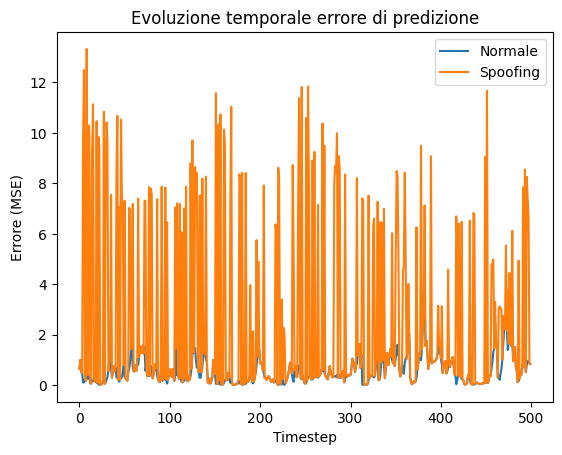

In [17]:
plt.plot(err_clean[:500], label='Normale')
plt.plot(err_att[:500], label='Spoofing')
plt.xlabel("Timestep"); plt.ylabel("Errore (MSE)")
plt.title("Evoluzione temporale errore di predizione")
plt.legend(); plt.show()

# **ROC / PR curve**

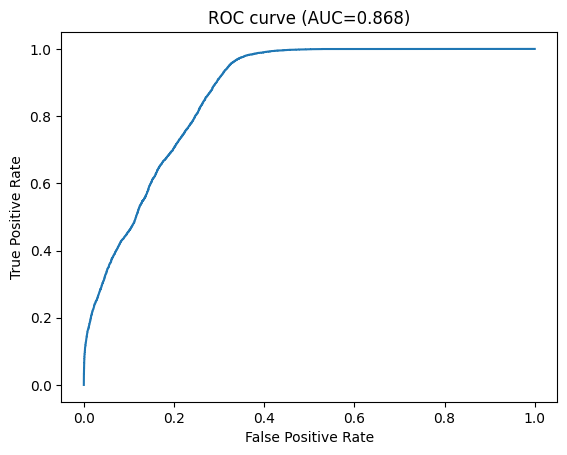

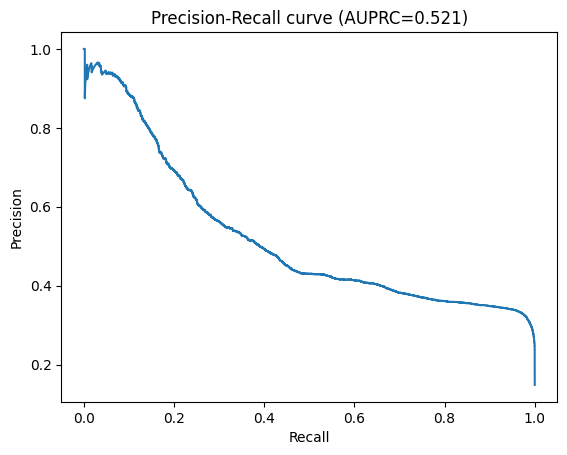

In [18]:
# --- importa la funzione originale ---
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# --- ricalcola ---
fpr, tpr, _ = roc_curve(labels_all, scores_all)
prec, rec, _ = precision_recall_curve(labels_all, scores_all)

roc_auc = auc(fpr, tpr)
pr_auc  = auc(rec, prec)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC curve (AUC={roc_auc:.3f})")
plt.show()

plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall curve (AUPRC={pr_auc:.3f})")
plt.show()


# **Heatmap “offset vs TPR”**

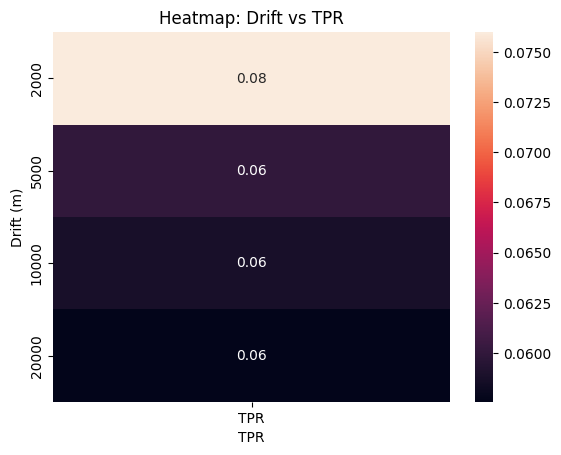

In [19]:
data = pd.DataFrame(results, columns=["drift_m", "TPR"])
sns.heatmap(data.pivot_table(index="drift_m", values="TPR"), annot=True, fmt=".2f")
plt.title("Heatmap: Drift vs TPR"); plt.xlabel("TPR"); plt.ylabel("Drift (m)")
plt.show()

# **Case study: traiettoria su piano cartesiano**

In [20]:
def predict_future(model, X_test, owners_test, df_test, i, std_xy, seq_len=SEQUENCE_LEN, future_len=FUTURE_LEN):
    model.eval()

    # --- input modello ---
    x = torch.tensor(X_test[i:i+1], dtype=torch.float32)

    with torch.no_grad():
        # predizione normalizzata
        pred_norm = model(x, y_teacher=None, tf_ratio=0.0)[0].cpu().numpy()  # (future_len,2)

    # --- denormalizzazione ---
    pred_rel = np.zeros_like(pred_norm)
    pred_rel[:,0] = pred_norm[:,0] * std_xy[0]
    pred_rel[:,1] = pred_norm[:,1] * std_xy[1]

    # --- ricostruzione coordinate assolute ---
    mmsi, offset = owners_test[i]
    g = df_test[df_test["MMSI"] == mmsi].sort_values("BaseDateTime")

    xy_abs = denorm_xy(g[["X","Y"]].values)
    last_xy_abs = xy_abs[offset + seq_len - 1]   # ultimo punto della history

    pred_abs = last_xy_abs + pred_rel

    return last_xy_abs, pred_abs

In [21]:
def get_hist_and_future_abs(df_split, owners_split, i,
                             seq_len=SEQUENCE_LEN,
                             future_len=FUTURE_LEN):

    mmsi, offset = owners_split[i]
    g = df_split[df_split["MMSI"] == mmsi].sort_values("BaseDateTime")

    xy_norm = g[["X","Y"]].to_numpy()
    xy_abs  = denorm_xy(xy_norm)

    s0 = offset
    s1 = offset + seq_len
    s2 = s1 + future_len

    if s2 > len(xy_abs):
        return None

    hist_abs   = xy_abs[s0:s1]
    future_abs = xy_abs[s1:s2]
    last_xy_abs = hist_abs[-1]

    return hist_abs, future_abs, last_xy_abs

In [22]:
def plot_case_study(model, df_split, owners_split, X_test, i, std_xy,
                     seq_len=SEQUENCE_LEN, future_len=FUTURE_LEN):

    out = get_hist_and_future_abs(df_split, owners_split, i, seq_len, future_len)
    if out is None:
        print("Finestra troppo corta.")
        return

    hist_abs, future_abs, last_xy_abs = out

    last_xy_abs_pred, pred_abs = predict_future(
        model, X_test, owners_split, df_split, i, std_xy, seq_len, future_len
    )

    plt.figure(figsize=(7,6))
    plt.plot(hist_abs[:,0],   hist_abs[:,1],   label="Storico")
    plt.plot(future_abs[:,0], future_abs[:,1], label="Reale futuro")
    plt.plot(pred_abs[:,0],   pred_abs[:,1],   label="Predetto")

    plt.axis("equal")
    plt.grid(True)
    plt.legend()
    plt.title(f"Predizione Traiettoria — sample {i}")
    plt.show()

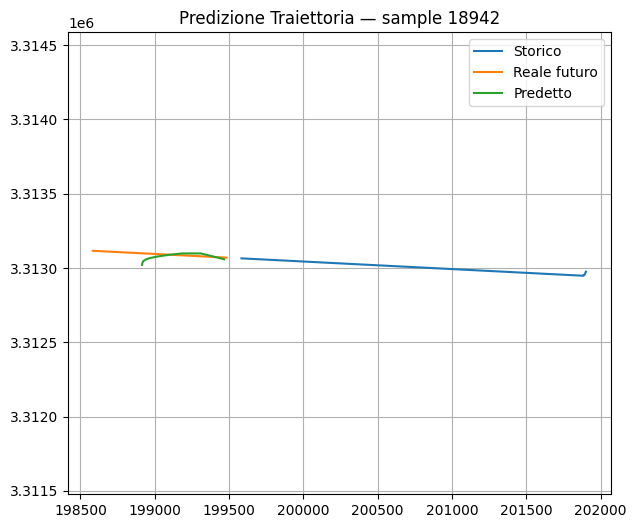

In [46]:
i = np.random.randint(0, len(X_test))
plot_case_study(model, df_test, owners_test, X_test, i, std_xy)